# Diode Clipper

In [1]:
import sys
import os

os.environ['PYTHONPATH']

'/home/chris/code/sax:/home/chris/code/circulus'

In [4]:
import jax
import jax.numpy as jnp
import diffrax

from circulus.components import Resistor, Diode, VoltageSourceAC
from circulus.compiler import compile_netlist
from circulus.solvers.strategies import DenseSolver
from circulus.solvers.transient import VectorizedTransientSolver
import time

import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

1. Compiling Circuit...
   System Size: 4 variables
   Port Map: {'R1,p2': 1, 'D2,p2': 1, 'D1,p1': 1, 'D2,p1': 0, 'GND,p1': 0, 'Vin,p2': 0, 'D1,p2': 0, 'Vin,p1': 2, 'R1,p1': 2}
2. Initializing Solver Strategy...
3. Solving DC Operating Point...
   DC Solution (First 5): [0. 0. 0. 0.]
4. Running Transient Simulation...
   ✅ Simulation Successful
Performed 674 steps performed in 1.78 seconds


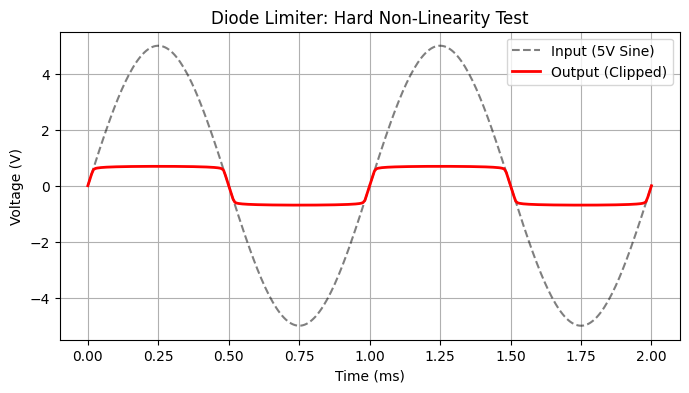

In [5]:


models_map ={
    'resistor': Resistor,
    'diode': Diode,
    'source_voltage': VoltageSourceAC,
    'ground': lambda: 0
}

net_dict ={
    "instances": {
        "GND": {"component":"ground"},
        "Vin": {"component":"source_voltage", "settings":{"V": 5.0, "freq": 1e3,}},
        "R1":  {"component":"resistor", "settings":{"R": 1000.0}},
        "D1":  {"component":"diode", "settings":{'Is':1e-14,}},
        "D2":  {"component":"diode", "settings":{'Is':1e-14,}},
    },
    "connections": {
        "GND,p1": ("Vin,p2", "D1,p2", "D2,p1"),
        "Vin,p1": "R1,p1",
        "R1,p2":  ("D1,p1", "D2,p2"),
    },
}

print("1. Compiling Circuit...")
groups, num_vars, port_map = compile_netlist(net_dict, models_map)
print(f"   System Size: {num_vars} variables")
print(f"   Port Map: {port_map}")

print("2. Initializing Solver Strategy...")
linear_strat = DenseSolver.from_circuit(groups, num_vars, is_complex=False)

print("3. Solving DC Operating Point...")
y_guess = jnp.zeros(num_vars)
y_dc = linear_strat.solve_dc(groups, y_guess)
print(f"   DC Solution (First 5): {y_dc[:5]}")

print("4. Running Transient Simulation...")

t_max = 2E-3
saveat = diffrax.SaveAt(ts=jnp.linspace(0, t_max, 300))

solver = VectorizedTransientSolver(linear_solver=linear_strat)

term = diffrax.ODETerm(lambda t, y, args: jnp.zeros_like(y))

step_controller = diffrax.PIDController(
    rtol=1e-3, 
    atol=1e-6,  
    pcoeff=0.2, 
    icoeff=0.5,
    dcoeff=0.4,
    force_dtmin=True,
    dtmin=1E-8,
    dtmax=1e-5,
    error_order=2
)

start = time.time()
sol = diffrax.diffeqsolve(
    terms=term,
    solver=solver,
    t0=0.0,
    t1=t_max,
    dt0=1e-7, 
    y0=y_dc,
    args=(groups, num_vars),
    saveat=saveat,
    max_steps=100000,
    throw=False,
    stepsize_controller=step_controller
)
stop = time.time()

if sol.result == diffrax.RESULTS.successful:
    print("   ✅ Simulation Successful")
    print(f"Performed {sol.stats['num_steps']} steps performed in {stop-start:.2f} seconds")
    ts = sol.ts
    v_in = sol.ys[:, port_map['Vin,p1']]
    v_out = sol.ys[:, port_map['R1,p2']]

    plt.figure(figsize=(8, 4))
    plt.plot(ts*1000, v_in, 'k--', alpha=0.5, label='Input (5V Sine)')
    plt.plot(ts*1000, v_out, 'r-', linewidth=2, label='Output (Clipped)')
    plt.title("Diode Limiter: Hard Non-Linearity Test")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("   ❌ Simulation Failed")
    print(f"   Result Code: {sol.result}")